<a href="https://colab.research.google.com/github/fabianimarco98/cinema-prediction-ML/blob/main/slowcinema_ML_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statistics  as stat
import matplotlib.pyplot as plt
from collections import Counter
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from google.colab import drive
drive.mount('/content/drive')
#from google.colab import files
#uploaded = files.upload()

Mounted at /content/drive


sotto il codice per aprire e pulire il dataset e per fare domanda API ed ottenere i generi dei film

In [ ]:
# @title
'''apertura e formattazione df --> non fare sempre perchè lo carico coi dati dopo'''

import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csv/df.csv",sep=";",encoding='unicode_escape')
#sostituisce NaN con 0
df = df.fillna(0)
df['DATA'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y', errors='coerce')
#ora vorrei aggiungere colonna per: mercoledì, sabato e domenica
df["giorno"] = df["DATA"].dt.weekday + 1
# Crea una nuova colonna per indicare se il giorno è mercoledì --> sospeso
#df['merc'] = df['giorno'].apply(lambda giorno: True if giorno == 3 else False)
#df=df.drop("giorno",axis=1)
#aggiugne riga mese
df['mese'] = df['DATA'].dt.month
#RIMUOVE RIGHE CON -
df = df[~df.isin(['-']).any(axis=1)]
# Convert fund columns to numeric, replacing non-numeric values with NaN
df.loc[:, 'FONDO CASSA FINALE'] = pd.to_numeric(df['FONDO CASSA FINALE'], errors='coerce')
df.loc[:, 'FONDO CASSA INIZIALE'] = pd.to_numeric(df['FONDO CASSA INIZIALE'], errors='coerce')
df.loc[:, 'INCASSO ATTESO'] = pd.to_numeric(df['INCASSO ATTESO'], errors='coerce')
df.loc[:, 'TOT'] = pd.to_numeric(df['TOT'], errors='coerce')
df.loc[:, 'RIDOTTI'] = pd.to_numeric(df['RIDOTTI'], errors='coerce')
df.loc[:, 'INTERI'] = pd.to_numeric(df['INTERI'], errors='coerce')
df.loc[:, 'TOT']=df.loc[:, 'INTERI']+df.loc[:, 'RIDOTTI']

df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/csv/df.csv'

In [ ]:
# @title
"ottengo generi e altri dati via API per i film --> non eseguire sempre"

def get_genre_ids(df):
    api_key = ""  # tMDb API key
    generi = []  # Lista per memorizzare i generi
    lingue=[]
    popolarità=[]
    rating=[]
    id=[]
    #overview=[]
    for index, row in df.iterrows():
        movie_title = row["TITOLO"]
        if movie_title.endswith(" - Piacere del Cinema"):
            movie_title=movie_title[:-21]
        url = "https://api.themoviedb.org/3/search/movie"
        params = {
            'api_key': api_key,
            'query': movie_title,
            'language': 'it-IT',  # Imposta la lingua italiana
        }
        response = requests.get(url, params=params) #timeout=250
        if response.status_code == 200:
            movie_data = response.json()
            #print([genere["genre_ids"] for genere in movie_data["results"]])

            # Controlla se ci sono generi disponibili
            if movie_data["results"]: #è una lista
                #print(movie_data["results"])
                #genre_ids = [genere["genre_ids"] for genere in movie_data["results"]]
                genre_ids = movie_data["results"][0]["genre_ids"] #prende solo la prima lista di generi
                generi.append(genre_ids)
                lingua=movie_data["results"][0]["original_language"]
                lingue.append(lingua)
                popolarità_singola=movie_data["results"][0]["popularity"]
                popolarità.append(popolarità_singola)
                rating_singolo=movie_data["results"][0]["vote_average"]
                rating.append(rating_singolo)
                id_singolo=movie_data["results"][0]["id"]
                id.append(id_singolo)
                #overview_singola=movie_data["results"][0]["overview"]
                #overview.append(overview_singola)
            else:
                generi.append([])  # Nessun genere disponibile per questo film
                lingue.append([])
                popolarità.append([])
                rating.append([])
                id.append([])
                #overview.append([])
        else:
            print(f"Error: {response.status_code}")
            print(response.text)
            generi.append([])  # Nessuna risposta positiva per questo film
            lingue.append([])
            popolarità.append([])
            rating.append([])
            id.append([])
            #overview.append([])
    # Aggiungi una colonna al DataFrame con gli ID dei generi
    df["genre_ids"] = generi
    df["original_language"]=lingue
    df['popularity']=popolarità
    df["rating"]=rating
    df["id"]=id
    #df['overview']=overview
    df = df[df['genre_ids'].apply(lambda x: len(x) > 0)]  # Rimuovi le righe con liste vuote
    df = df[df['original_language'].apply(lambda x: len(x) > 0)]
    return df

#colonneselezionate = ['TITOLO', 'INTERI', 'RIDOTTI','TOT'] --> cambio le colonne
#df["rid"]=df["RIDOTTI"]/df["TOT"]
colonneselezionate = ['TITOLO', 'mese','TOT','ORA','giorno','INCASSO ATTESO','RIDOTTI']
df_titoli = df.loc[:, colonneselezionate].copy()
df2=get_genre_ids(df_titoli)
df2

,TITOLO,mese,TOT,ORA,giorno,INCASSO ATTESO,RIDOTTI,genre_ids,original_language,popularity,rating,id
0,Il Re Leone,9,184,20:30,6,1086.0,101,"[12, 18, 10751, 16]",en,118.464,7.1,420818
2,Il Re Leone,9,57,20:30,7,405.0,22,"[12, 18, 10751, 16]",en,118.464,7.1,420818
4,IT - Capitolo 2,9,198,20:30,6,1160.0,123,[27],en,113.318,6.844,474350
5,Angry Birds 2,9,55,17:00,7,305.0,40,"[16, 35, 12, 10751]",en,86.275,7.087,454640
6,IT - Capitolo 2,10,64,20:30,2,400.0,24,[27],en,113.318,6.844,474350
...,...,...,...,...,...,...,...,...,...,...,...,...
511,Furiosa,6,4,20:30,7,NaN,1,"[28, 12, 878]",en,2656.928,7.657,786892
512,Inside Out 2,6,285,20:30,3,NaN,224,"[16, 10751, 12, 35, 18]",en,8079.644,7.695,1022789
513,Inside Out 2,6,262,20:30,6,NaN,181,"[16, 10751, 12, 35, 18]",en,8079.644,7.695,1022789
514,Inside Out 2,6,290,17:00,7,NaN,187,"[16, 10751, 12, 35, 18]",en,8079.644,7.695,1022789


In [ ]:
import requests
import pandas as pd

# Funzione per ottenere i dettagli del film e aggiornare il DataFrame
def get_movie_details(df):
    api_key = ""  # TMDb API key
    cast_list = []
    director_list = []
    budget_list = []
    production_list = []
    keyword_list = []

    for index, row in df.iterrows():
        movie_title = row["TITOLO"]
        tmdb_id = row["id"]
        if movie_title.endswith(" - Piacere del Cinema"):
            movie_title = movie_title[:-21]

        # Ottenere i crediti del film
        url_credits = f'https://api.themoviedb.org/3/movie/{tmdb_id}/credits'
        params = {
            'api_key': api_key,
            'language': 'it-IT',  # Imposta la lingua italiana
        }
        response_credits = requests.get(url_credits, params=params)

        if response_credits.status_code == 200:
            data_credits = response_credits.json()
            cast = [member['name'] for member in data_credits['cast'][:5]]  # primi 5 attori
            director = [member['name'] for member in data_credits['crew'] if member['job'] == 'Director']
            cast_list.append(cast)
            director_list.append(director[0] if director else None)
        else:
            cast_list.append([])
            director_list.append(None)

        # Ottenere i dettagli del film
        url_details = f'https://api.themoviedb.org/3/movie/{tmdb_id}'
        response_details = requests.get(url_details, params=params)

        if response_details.status_code == 200:
            data_details = response_details.json()
            budget = data_details.get('budget', None)
            budget_list.append(budget)
            production_companies = data_details.get('production_companies', [])
            first_production_company = production_companies[0]['name'] if production_companies else None
            production_list.append(first_production_company)
        else:
            budget_list.append(None)
            production_list.append([])

        # Ottenere le keyword del film
        url_keywords = f'https://api.themoviedb.org/3/movie/{tmdb_id}/keywords'
        response_keywords = requests.get(url_keywords, params=params)

        if response_keywords.status_code == 200:
            data_keywords = response_keywords.json()
            keywords = [keyword['name'] for keyword in data_keywords.get('keywords', [])]
            keyword_list.append(keywords)
        else:
            keyword_list.append([])

    df['cast'] = cast_list
    df['director'] = director_list
    df['budget'] = budget_list
    df['production_company'] = production_list
    df['keywords'] = keyword_list
    return df

# Esegui la funzione
df2 = get_movie_details(df2)

# Salva il DataFrame aggiornato su file
df2.to_csv("/content/drive/MyDrive/Colab Notebooks/csv/df2.csv", index=False)
df2


,TITOLO,mese,TOT,ORA,giorno,INCASSO ATTESO,RIDOTTI,genre_ids,original_language,popularity,rating,id,cast,director,budget,production_company,keywords
0,Il Re Leone,9,184,20:30,6,1086.0,101,"[12, 18, 10751, 16]",en,118.464,7.1,420818,"[Chiwetel Ejiofor, John Oliver, Donald Glover,...",Jon Favreau,260000000,Walt Disney Pictures,"[africa, lion, prince, redemption, musical, un..."
2,Il Re Leone,9,57,20:30,7,405.0,22,"[12, 18, 10751, 16]",en,118.464,7.1,420818,"[Chiwetel Ejiofor, John Oliver, Donald Glover,...",Jon Favreau,260000000,Walt Disney Pictures,"[africa, lion, prince, redemption, musical, un..."
4,IT - Capitolo 2,9,198,20:30,6,1160.0,123,[27],en,113.318,6.844,474350,"[Jessica Chastain, James McAvoy, Bill Hader, I...",Andy Muschietti,79000000,New Line Cinema,"[based on novel or book, clown, carnival, sequ..."
5,Angry Birds 2,9,55,17:00,7,305.0,40,"[16, 35, 12, 10751]",en,86.275,7.087,454640,"[Jason Sudeikis, Josh Gad, Danny McBride, Lesl...",Thurop Van Orman,65000000,Rovio Animation,"[island, rivalry, sequel, family, animal kingdom]"
6,IT - Capitolo 2,10,64,20:30,2,400.0,24,[27],en,113.318,6.844,474350,"[Jessica Chastain, James McAvoy, Bill Hader, I...",Andy Muschietti,79000000,New Line Cinema,"[based on novel or book, clown, carnival, sequ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,Furiosa,6,4,20:30,7,NaN,1,"[28, 12, 878]",en,2656.928,7.657,786892,"[Anya Taylor-Joy, Chris Hemsworth, Tom Burke, ...",George Miller,170000000,Warner Bros. Pictures,"[post-apocalyptic future, prequel, spin off, t..."
512,Inside Out 2,6,285,20:30,3,NaN,224,"[16, 10751, 12, 35, 18]",en,8079.644,7.695,1022789,"[Amy Poehler, Maya Hawke, Kensington Tallman, ...",Kelsey Mann,200000000,Walt Disney Pictures,"[sadness, disgust, sequel, computer animation,..."
513,Inside Out 2,6,262,20:30,6,NaN,181,"[16, 10751, 12, 35, 18]",en,8079.644,7.695,1022789,"[Amy Poehler, Maya Hawke, Kensington Tallman, ...",Kelsey Mann,200000000,Walt Disney Pictures,"[sadness, disgust, sequel, computer animation,..."
514,Inside Out 2,6,290,17:00,7,NaN,187,"[16, 10751, 12, 35, 18]",en,8079.644,7.695,1022789,"[Amy Poehler, Maya Hawke, Kensington Tallman, ...",Kelsey Mann,200000000,Walt Disney Pictures,"[sadness, disgust, sequel, computer animation,..."


In [ ]:
"pulisco il dataset precedente"

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csv/df2.csv",sep=",") #carico df con già i generi
df = df.fillna(0)
# Rimuovi le righe in cui la colonna 'ORA' non contiene il carattere ':'
df = df[df['ORA'].str.contains(':')]
from datetime import datetime
# Supponiamo che 'ORA' sia una colonna nel tuo DataFrame con orari come '17:00' e '20:30'
df['ORA'] = pd.to_datetime(df['ORA'], format='%H:%M', errors='coerce')
# Ora puoi usare .dt accessor per ottenere l'ora
df['fascia_oraria'] = df['ORA'].dt.hour.apply(lambda hour: '8' if 6 <= hour < 12 else '17' if 12 <= hour < 18 else '20')
#tolgo ora perchè ho le fasce orarie
df = df.drop('ORA', axis=1)
#df = df.drop('overview', axis=1)

# Seleziona solo le righe con valori numerici nella colonna 'popularity' --> al momento sospeso perchè non la uso
#df = df[pd.to_numeric(df['popularity'], errors='coerce').notna()]
#tolgo perchè secondo me non ha senso usarla
df=df.drop("popularity",axis=1)
df=df.drop("id",axis=1)
df = df[df['production_company']!=0]

df["weekend"]=df["giorno"]!=3
#df['weekend'] = df['weekend'].astype(int)
# Mappare original_language a valori numerici
lang_mapping = {'en': 0, 'it': 1, 'fr': 2, 'es': 3, 'de': 4}  # Esempio di mappatura
df['original_language_numeric'] = df['original_language'].map(lang_mapping)
#df.dtypes
df.head(4)

,TITOLO,mese,TOT,giorno,INCASSO ATTESO,RIDOTTI,genre_ids,original_language,rating,cast,director,budget,production_company,keywords,fascia_oraria,weekend,original_language_numeric
0,Il Re Leone,9,184,6,1086.0,101,"[12, 18, 10751, 16]",en,7.100,"['Chiwetel Ejiofor', 'John Oliver', 'Donald Gl...",Jon Favreau,260000000,Walt Disney Pictures,"['africa', 'lion', 'prince', 'redemption', 'mu...",20,True,0.0
1,Il Re Leone,9,57,7,405.0,22,"[12, 18, 10751, 16]",en,7.100,"['Chiwetel Ejiofor', 'John Oliver', 'Donald Gl...",Jon Favreau,260000000,Walt Disney Pictures,"['africa', 'lion', 'prince', 'redemption', 'mu...",20,True,0.0
2,IT - Capitolo 2,9,198,6,1160.0,123,[27],en,6.844,"['Jessica Chastain', 'James McAvoy', 'Bill Had...",Andy Muschietti,79000000,New Line Cinema,"['based on novel or book', 'clown', 'carnival'...",20,True,0.0
3,Angry Birds 2,9,55,7,305.0,40,"[16, 35, 12, 10751]",en,7.087,"['Jason Sudeikis', 'Josh Gad', 'Danny McBride'...",Thurop Van Orman,65000000,Rovio Animation,"['island', 'rivalry', 'sequel', 'family', 'ani...",17,True,0.0


di seguito 6 analisi sui generi

In [ ]:
# @title
# Creiamo una lista di tutti i generi unici presenti in 'genre_ids' -->one hot encoding dei generi
unique_genres = set()
for genres_list in df['genre_ids']:
  # Rimuovi le parentesi quadre
  generi = genres_list.strip("[]")
  #print(generi)
  # Split per virgola e rimozione degli spazi
  generi_lista = [genre.strip().replace(' ', '') for genre in generi.split(',')]
  #generi_lista=generi.split(",")
  #print(generi_lista)
  for genere in generi_lista:
    #print(genere)
    unique_genres.add(genere)

# Creiamo una colonna per ogni genere unico e assegniamo 0 o 1 a seconda se il genere è presente nel film
for genre in unique_genres:
    df[f'genre_{genre}'] = df['genre_ids'].apply(lambda x: 1 if genre in x else 0)

In [ ]:
# @title
# Seleziona le colonne dal decimo in poi
colonne_da_selezionare = df.columns[11:]
#creo un df con solo i generi one hot
df_generi = df[colonne_da_selezionare]
#lista di nomi dei generi
nomi_generi = df_generi.columns.tolist()
TOT_per_genere = []

# Itera attraverso ogni genere e crea una lista di dati per il boxplot
for genere in nomi_generi:
    TOT_per_genere.append(df[df[genere] == 1]['TOT'])

plt.figure(figsize=(10, 6))
plt.boxplot(TOT_per_genere, labels=nomi_generi)
plt.title('Boxplot di TOT per genre_ids')
plt.xticks(fontsize=9)
plt.xlabel('genre_ids')
plt.ylabel('TOT')
plt.grid(True)

In [ ]:
# @title
# ANOVA PER CAPIRE SE I GENERI DETERMINANO UN TOTALE DIVERSO
from scipy.stats import f_oneway
# Creazione del dizionario
genere_tot_dict = {}

# Iterazione attraverso ogni genere
for genere in nomi_generi:
    # Seleziona i valori TOT per il genere corrente e aggiungili al dizionario
    genere_tot_dict[genere] = df[df[genere] == 1]['TOT'].tolist()

# Lista dei gruppi di dati TOT per ciascun genere
gruppi_tot = list(genere_tot_dict.values())

# Esegui ANOVA
statistiche, p_valore = f_oneway(*gruppi_tot)

# Interpretazione del risultato
livello_di_significatività = 0.05
if p_valore < livello_di_significatività:
    print(f"Il test ANOVA suggerisce che esiste almeno una differenza significativa tra i gruppi di generi (p-value = {p_valore})")
else:
    print(f"Il test ANOVA non ha trovato evidenze sufficienti per rigettare l'ipotesi nulla di non differenza tra i gruppi (p-value = {p_valore})")


In [ ]:
# @title
# MEDIA PER GENERE E QUANTO SI DISCOSTANO DALLA MEDIA GLOBALE

# Calcola la media globale dei valori TOT
media_tot_globale = sum(sum(genere_tot_dict[genere]) for genere in genere_tot_dict) / sum(len(genere_tot_dict[genere]) for genere in genere_tot_dict)

# Calcola la media dei valori TOT per ciascun genere
media_per_genere = {genere: sum(genere_tot_dict[genere]) / len(genere_tot_dict[genere]) for genere in genere_tot_dict}

# Trova il genere che si discosta di più dalla media globale
genere_massima_discordanza = max(media_per_genere, key=lambda genere: abs(media_per_genere[genere] - media_tot_globale))
massima_discordanza = abs(media_per_genere[genere_massima_discordanza] - media_tot_globale)

# Trova il genere che si discosta di meno dalla media globale
genere_minima_discordanza = min(media_per_genere, key=lambda genere: abs(media_per_genere[genere] - media_tot_globale))
minima_discordanza = abs(media_per_genere[genere_minima_discordanza] - media_tot_globale)

print(f"Media globale dei valori TOT: {media_tot_globale:.2f}")
print(f"Media per genere:")
for genere, media in media_per_genere.items():
    print(f"{genere}: {media:.2f}")

print(f"\nGenere che si discosta di più dalla media globale: {genere_massima_discordanza} "
      f"(Discordanza: {massima_discordanza:.2f})")
print(f"Genere che si discosta di meno dalla media globale: {genere_minima_discordanza} "
      f"(Discordanza: {minima_discordanza:.2f})")

In [ ]:
# @title
# DEVIAZIONE STANDARD INTERNA AI GENERI

# Calcola la deviazione standard dei valori TOT per ciascun genere
deviazione_std_per_genere = {genere: np.std(genere_tot_dict[genere]) for genere in genere_tot_dict}

# Trova il genere che presenta la maggiore deviazione standard
genere_massima_deviazione_std = max(deviazione_std_per_genere, key=deviazione_std_per_genere.get)
massima_deviazione_std = deviazione_std_per_genere[genere_massima_deviazione_std]

print("Deviazione standard per genere:")
for genere, deviazione_std in deviazione_std_per_genere.items():
    print(f"{genere}: {deviazione_std:.2f}")

print(f"\nGenere che presenta la maggiore deviazione standard: {genere_massima_deviazione_std} "
      f"(Deviazione standard: {massima_deviazione_std:.2f})")

In [ ]:
# @title
from ast import literal_eval
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Converti le stringhe di genre_ids in liste di interi usando literal_eval
df['genre_ids'] = df['genre_ids'].apply(literal_eval)

# Calcola la lunghezza massima delle liste di genre_ids
max_length = df['genre_ids'].apply(len).max()

# Applica il padding alle sequenze
df['genre_ids_padded'] = pad_sequences(df['genre_ids'], maxlen=max_length, padding='post').tolist()

df.head(1)

In [ ]:
# @title
# Lista di attori di interesse
attore_di_interesse = 'Brad Pitt'

# Calcolo della presenza dell'attore di interesse nel cast
df['attore_presente'] = df['cast'].apply(lambda cast: attore_di_interesse in cast)

# Calcolo della correlazione tra la presenza dell'attore e l'incasso totale (TOT)
correlation = df['attore_presente'].astype(int).corr(df['TOT'])

print(f"Correlazione tra la presenza di '{attore_di_interesse}' e TOT:", correlation)

regista_di_interesse = 'Christopher Nolan'

# Calcolo della presenza del regista di interesse nel DataFrame
df['regista_presente'] = (df['director'] == regista_di_interesse)

# Calcolo della correlazione tra la presenza del regista e TOT
correlation = df['regista_presente'].astype(int).corr(df['TOT'])

print(f"Correlazione tra la presenza di '{regista_di_interesse}' e TOT:", correlation)

# Lista di CASE di interese
studio_di_interesse = 'Walt Disney Pictures'

# Calcolo della presenza dello studio di produzione di interesse nel DataFrame
df['studio_presente'] = (df['production_company'] == studio_di_interesse)

# Calcolo della correlazione tra la presenza dello studio di produzione e TOT
correlation = df['studio_presente'].astype(int).corr(df['TOT'])

print(f"Correlazione tra la presenza di '{studio_di_interesse}' e TOT:", correlation)

Correlazione tra la presenza di 'Brad Pitt' e TOT: -0.049281342932980705
Correlazione tra la presenza di 'Christopher Nolan' e TOT: 0.035268370001658354
Correlazione tra la presenza di 'Walt Disney Pictures' e TOT: 0.3799063718139746


In [ ]:
# @title
# Esegui One-Hot Encoding per "cast"
mlb = MultiLabelBinarizer()
cast_encoded = pd.DataFrame(mlb.fit_transform(df2['cast']), columns=mlb.classes_, index=df2.index)

# Unisci i dati codificati al DataFrame originale, escludendo le colonne non numeriche
df_encoded_cast = pd.concat([df2[['TOT']], cast_encoded], axis=1)

# Calcola la correlazione con 'TOT'
correlation_matrix_cast = df_encoded_cast.corr()
tot_correlation_cast = correlation_matrix_cast['TOT'].sort_values(ascending=False)

# Mostra le correlazioni con TOT
print("Correlazioni con TOT:")
tot_correlation_cast.head(5)

Correlazioni con TOT:


AttributeError: 'Series' object has no attribute 'plt'

Correlazioni con TOT > 30% o < 5%:
TOT                   1.000000
sadness               0.398074
embarrasment          0.398074
emotions              0.398074
anger                 0.398074
envy                  0.398074
disgust               0.398074
joy                   0.398074
anxiety               0.398074
computer animation    0.395245
fear                  0.377286
admiring              0.341349
female director       0.312473
pastiche              0.312473
post-war italy        0.312473
women empowerment     0.312473
teenager             -0.100740
2000s                -0.100796
1950s                -0.101335
tense                -0.106923
infidelity           -0.111242
sports               -0.114709
Name: TOT, dtype: float64


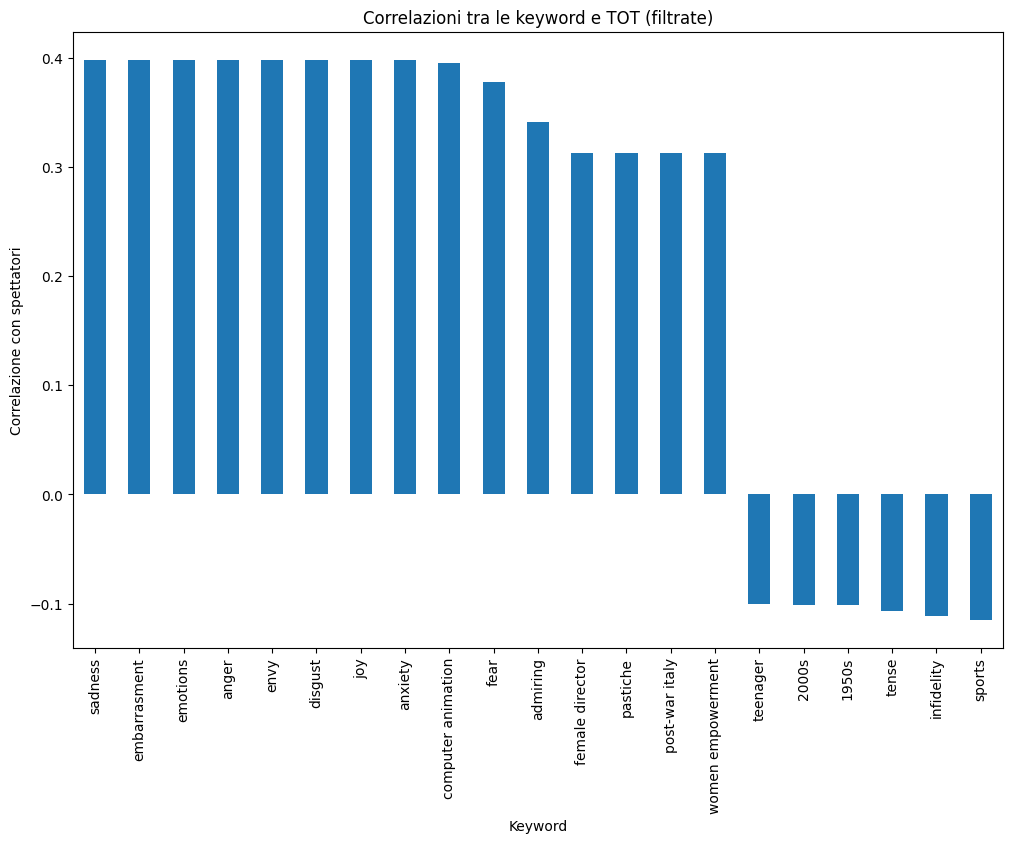

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

# Esegui One-Hot Encoding per "keywords"
mlb = MultiLabelBinarizer()
keywords_encoded = pd.DataFrame(mlb.fit_transform(df2['keywords']), columns=mlb.classes_, index=df2.index)

# Unisci i dati codificati al DataFrame originale
df_encoded_keywords = pd.concat([df2[['TOT']], keywords_encoded], axis=1)

# Calcola la correlazione con 'TOT'
correlation_matrix_keywords = df_encoded_keywords.corr()
tot_correlation_keywords = correlation_matrix_keywords['TOT'].sort_values(ascending=False)

# Filtra le correlazioni > 30% e < 5%
filtered_correlation_keywords = tot_correlation_keywords[
    (tot_correlation_keywords > 0.30) | (tot_correlation_keywords < -0.10)
]

# Mostra le correlazioni filtrate con TOT
print("Correlazioni con TOT > 30% o < 5%:")
print(filtered_correlation_keywords)

# Visualizza le correlazioni filtrate con TOT tramite un grafico a barre
plt.figure(figsize=(12, 8))
filtered_correlation_keywords[1:].plot(kind='bar')
plt.title('Correlazioni tra le keyword e TOT (filtrate)')
plt.xlabel('Keyword')
plt.ylabel('Correlazione con spettatori')
plt.show()


In [ ]:
# @title
# One-Hot Encoding per "production_company"
production_encoded = pd.get_dummies(df2['production_company'])

# Unisci i dati codificati al DataFrame originale, escludendo le colonne non numeriche
df_encoded_prod = pd.concat([df2[['TOT']], production_encoded], axis=1)

# Calcola la correlazione con 'TOT'
correlation_matrix_prod = df_encoded_prod.corr()
tot_correlation_prod = correlation_matrix_prod['TOT'].sort_values(ascending=False)

# Mostra le correlazioni con TOT
print("Correlazioni con TOT:")
tot_correlation_prod.head(5)

TypeError: unhashable type: 'list'

In [ ]:
#ADDESTRO MODELLO

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import joblib

# Definisci le colonne delle features e del target
features = ['genre_ids','mese','production_company'] #,'mese','original_language', 'genre_ids' 'weekend' 'fascia_oraria','TITOLO',
target = 'TOT'


# Concatena tutte le colonne al DataFrame
df_encoded = pd.concat([df[[target] + features]], axis=1)
df_encoded['genre_ids'] = df_encoded['genre_ids'].apply(lambda x: '_'.join(map(str, x)))
# Dividi il dataset in set di addestramento e test
train_df, test_df = train_test_split(df_encoded, test_size=0.15, random_state=42)

# Definisci il preprocessor per il one-hot encoding su tutte le colonne categoriche
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features)  # Ignora le categorie sconosciute durante la trasformazione
    ],
    remainder='passthrough'
)


# Crea il pipeline con il preprocessor e il modello Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# Addestra il modello
pipeline.fit(train_df[features], train_df[target])

# Effettua le predizioni
predictions = pipeline.predict(test_df[features])

# Calcola l'errore medio quadratico (MSE)
mse = mean_squared_error(test_df[target], predictions)
mae = mean_absolute_error(test_df[target], predictions)
rmse=np.sqrt(mse)

model_path = "/content/drive/MyDrive/Colab Notebooks/models/SC_random_forest_model.pkl"
# Salva il modello
joblib.dump(pipeline, model_path)

# Stampa l'MSE
print("Mean Absolute Error:", mae)

Mean Absolute Error: 24.119603592314117


another RF

In [ ]:
# @title
# ADDESTRO MODELLLO CON GENERI IN ONEHOT

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib


# Definisci le colonne delle features e del target
features = ['mese', 'original_language'] + [col for col in df.columns if col.isdigit()]  # Categoriche prima, poi one-hot per i generi
target = 'TOT'
df_addestramento = df[features + [target]]
df_addestramento = df_addestramento.replace({1: True, 0: False})

# Dividi il dataset in set di addestramento e test
train_df, test_df = train_test_split(df_addestramento, test_size=0.2, random_state=42)
# Definisci il preprocessor per le colonne categoriche e per le colonne numeriche one-hot
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['mese', 'original_language']),  # Encoding per le variabili categoriche
        ('num', StandardScaler(), [col for col in df.columns if col.isdigit()])  # Standardizzazione per le colonne numeriche
    ],
    remainder='passthrough'
)

# Crea il modello RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Crea il pipeline con il preprocessor e il modello Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])
# Addestra il modello
pipeline.fit(train_df[features], train_df[target])
# Effettua le predizioni
predictions = pipeline.predict(test_df[features])
# Calcola l'errore medio quadratico (MSE)
mse = mean_squared_error(test_df[target], predictions)

# Stampa l'errore medio quadratico (MSE)
print("Mean Squared Error:", mse)

Mean Squared Error: 3418.148506696225


feature importance

In [ ]:
# @title
# Recupera le feature importances
feature_importances = pipeline.named_steps['model'].feature_importances_

# Recupera i nomi delle colonne dopo il preprocessing
preprocessed_columns = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=features)

# Associa le feature importances ai nomi delle colonne
feature_importances_dict = dict(zip(preprocessed_columns, feature_importances))

# Stampare le feature con le relative importanze
print("Feature Importances:")
for feature, importance in feature_importances_dict.items():
    print(f"{feature}: {importance}")

In [ ]:
# Carica il modello salvato

loaded_model = joblib.load(model_path)
# Effettua le predizioni sul set di test utilizzando il modello caricato
predictions_loaded_model = loaded_model.predict(test_df[features])
# Calcola l'errore medio quadratico (MSE) per il modello caricato
mse_loaded_model = mean_squared_error(test_df[target], predictions_loaded_model)
# Stampa l'MSE del modello caricato
print("Mean Squared Error (Loaded Model):", mse_loaded_model)
# Confronta le predizioni del modello caricato con i valori reali
comparison_df = pd.DataFrame({
    'Reali': test_df[target],
    'Predizioni': predictions_loaded_model,
    'Casa di produzione' : test_df["production_company"],
    'Titolo' : test_df["TITOLO"]
})
# Stampa il DataFrame con le predizioni e i valori reali
print(comparison_df)

Mean Squared Error (Loaded Model): 1229.4249796498352
     Reali  Predizioni       Casa di produzione                      Titolo
298     54   56.344000    Warner Bros. Pictures                     Aquaman
366     45   36.082000      Monumental Pictures               Back to Black
269    202  178.825333                 Wildside           C'è Ancora Domani
161     55   54.937167                Agidi Due            Il grande giorno
149     95  127.344167     DreamWorks Animation    Il Gatto con gli Stivali
..     ...         ...                      ...                         ...
74      38   33.978333    Warner Bros. Pictures              Richard Jewell
219     41   20.096429           Amazon Studios                         Air
349      8   22.510500  Arcadia Motion Pictures          il mio amico robot
159    139   80.323500     20th Century Studios  Avatar - la via dell'acqua
206     43   24.926333             Thunder Road                 John Wick 4

[76 rows x 4 columns]


In [ ]:
import matplotlib.pyplot as plt

# Crea un scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(test_df[target], predictions_loaded_model, color='blue', alpha=0.5)

# Aggiungi una linea diagonale per rappresentare la perfetta predizione
plt.plot(test_df[target], test_df[target], color='red')

# Aggiungi etichette e titolo
plt.title('Confronto tra Valori Predetti e Valori Reali')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')

# Mostra il plot
plt.show()

In [ ]:
# @title
data_to_plot = []
for genre_ids in df['genre_ids'].explode().unique():
    data_to_plot.append(df[df['genre_ids'].apply(lambda x: genre_ids in x)]['TOT'])

# Etichette per i generi
genre_labels = df['genre_ids'].explode().unique()

# Creiamo il boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=genre_labels)
plt.title('Boxplot di TOT per genre_ids')
plt.xlabel('genre_ids')
plt.ylabel('TOT')
plt.grid(True)
plt.show()

In [ ]:
import requests

def find_genre_and_details(movie_title):
    api_key = ""  # TMDb API key
    url_search = "https://api.themoviedb.org/3/search/movie"

    params_search = {
        'api_key': api_key,
        'query': movie_title,
        'language': 'it-IT',  # Imposta la lingua italiana
    }

    response_search = requests.get(url_search, params=params_search)
    genre_ids = None

    if response_search.status_code == 200:
        movie_data = response_search.json()
        if movie_data["results"]:
            genre_ids = movie_data["results"][0]["genre_ids"]  # Prende solo la prima lista di generi
            tmdb_id = movie_data["results"][0]["id"]

    params_details = {
        'api_key': api_key,
        'language': 'it-IT',  # Imposta la lingua italiana
    }


    url_details = f'https://api.themoviedb.org/3/movie/{tmdb_id}'

    response_details = requests.get(url_details, params=params_details)
    budget = None
    first_production_company = None


    if response_details.status_code == 200:
        data_details = response_details.json()
        budget = data_details.get('budget', None)
        production_companies = data_details.get('production_companies', [])
        first_production_company = production_companies[0]['name'] if production_companies else None

    return genre_ids, budget, first_production_company

# Esempio di utilizzo
nome_film = input("Inserisci nome film da testare: ")
generi, budget, produzione = find_genre_and_details(nome_film)

print("Generi:", generi)
print("Budget:", budget)
print("Prima casa di produzione:", produzione)

Inserisci nome film da testare: Inside out 2
Generi: [16, 10751, 12, 35]
Budget: 200000000
Prima casa di produzione: Walt Disney Pictures


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Definisci le colonne delle features e del target
features = ['genre_ids','mese','production_company','rating']
target = 'TOT'

# Carica il modello addestrato e il ColumnTransformer
model_path = "/content/drive/MyDrive/Colab Notebooks/models/SC_random_forest_model.pkl"
loaded_model = joblib.load(model_path)
#preprocessor = joblib.load(pipeline_path)

# Predizione per un nuovo film
new_movie = {
    'genre_ids': generi,
    'mese':6,
    'production_company': produzione
}

new_movie_df = pd.DataFrame([new_movie])
new_movie_df['genre_ids'] = new_movie_df['genre_ids'].apply(lambda x: '_'.join(map(str, x)))

# Effettua la predizione con il modello caricato
prediction = loaded_model.predict(new_movie_df)
print("Predizione TOT:", prediction)

Predizione TOT: [21.548]


In [ ]:
#provo SVR
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
features = ['mese', 'original_language', 'genre_ids','production_company']
target = 'TOT'
df_encoded = pd.concat([df[[target] + features]], axis=1)
df_encoded['genre_ids'] = df_encoded['genre_ids'].apply(lambda x: '_'.join(map(str, x)))
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='poly', C=89.56217116725531, epsilon=0.01272246979967082))  # Esempio di parametri, da ottimizzare
])

pipeline.fit(train_df[features], train_df[target])
predictions = pipeline.predict(test_df[features])
mse = mean_squared_error(test_df[target], predictions)
print("Mean Squared Error:", mse)
# Definisci il percorso dove salvare il modello
model_path = "/content/drive/MyDrive/Colab Notebooks/models/SVR_model.pkl"
# Salva il pipeline completo (preprocessor + modello SVR)
joblib.dump(pipeline, model_path)

Mean Squared Error: 1409.598137252582


['/content/drive/MyDrive/Colab Notebooks/models/SVR_model.pkl']

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Definisci le colonne delle features e del target
features = ['mese', 'original_language', 'genre_ids']
target = 'TOT'

# Carica il modello addestrato e il ColumnTransformer
model_path = "/content/drive/MyDrive/Colab Notebooks/models/SVR_model.pkl"
pipeline_path = "/content/drive/MyDrive/Colab Notebooks/models/SVR_column_transformer.pkl"

loaded_model = joblib.load(model_path)
preprocessor = joblib.load(pipeline_path)  # Carica il ColumnTransformer

# Predizione per un nuovo film
new_movie = {
    'mese': 6,
    'original_language': "en",
    'genre_ids': generi  # Esempio di nuovi generi per il film
}
new_movie_df = pd.DataFrame([new_movie])
new_movie_df['genre_ids'] = new_movie_df['genre_ids'].apply(lambda x: '_'.join(map(str, x)))

# Effettua la predizione con il modello caricato
# Applica la trasformazione del preprocessor
X_new = preprocessor.transform(new_movie_df[features])

# Effettua la predizione con il modello caricato
prediction = loaded_model.predict(X_new)
print("Predizione TOT:", prediction)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/models/SVR_column_transformer.pkl'

In [ ]:
# Funzione di trasformazione delle variabili categoriche
def transform_categorical(df, features):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded = encoder.fit_transform(df[features].astype(str))
    transformed_df = pd.DataFrame(encoded, columns=encoder.get_feature_names(features))
    return transformed_df

# Funzione obiettivo per l'ottimizzazione di Optuna
def objective(trial):
    # Definisci i parametri da ottimizzare
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': 42  # Imposta il seed per la riproducibilità
    }

    # Trasforma le variabili categoriche
    transformed_df = transform_categorical(df, ['original_language'])

    # Unisce le feature trasformate con le altre feature numeriche
    X = pd.concat([df[features].drop(columns=['original_language']), transformed_df], axis=1)

    # Dividi il dataset in training e validation set
    X_train, X_val, y_train, y_val = train_test_split(X, df[target], test_size=0.2, random_state=42)

    # Inizializza il modello Random Forest con i parametri proposti da Optuna
    model = RandomForestRegressor(**params)

    # Addestra il modello
    model.fit(X_train, y_train)

    # Calcola l'errore quadratico medio sul validation set
    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)

    return mse  # Ottimizza minimizzando l'errore quadratico medio

# Esegui l'ottimizzazione con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Visualizza i risultati dell'ottimizzazione
print("Miglior set di iperparametri:")
print(study.best_params)
print("Miglior valore di MSE trovato:", study.best_value)

[I 2024-06-19 15:07:03,392] A new study created in memory with name: no-name-5a9b3283-16c8-48c7-b5e2-92159d2d7038
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[W 2024-06-19 15:07:03,409] Trial 0 failed with parameters: {'n_estimators': 58, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'} because of the following error: AttributeError("'OneHotEncoder' object has no attribute 'get_feature_names'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-227-588df0ef3ed4>", line 21, in objective
    transformed_df = transform_categorical(df, ['original_language'])
  File "<ipython-input-227-588df

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'